In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly # https://plotly.com/python/
import random
import plotly.graph_objects as go
import plotly.express as px
from copy import deepcopy
from webcolors import name_to_rgb

# https://community.plotly.com/t/plotly-colours-list/11730/3
# https://community.plotly.com/t/different-colors-for-bars-in-barchart-by-their-value/6527/7
# https://plotly.com/python/continuous-error-bars/
# https://community.plotly.com/t/plotly-colours-list/11730/5

In [ ]:
# 1. plot the evolution in term of points, goal diff and goal scores wrt to leg and according to final rank
#      --> average path + standard deviation
# 2. Home/Away advantage : pts won; goal scored; goal conceded
# 2.b Rank Performance : pts won; goal scored; goal conceded (scatterplot)
# 3. Winter champion vs Final Champion // Winter situation vs Final situation
# 4. Team Performance wrt seasons : ranks, total goal scored and conceded, Home/Away results (min 10 seasons) 
# 5. Average/Std Team Performance wrt to legs (min 10 seasons) 

# 0. Data Preparation

In [ ]:
def prepare_data():
    # TO BE DONE IN REFACTO
    pass

In [135]:
serieA_df = pd.read_csv('serie-a_data_2004_2019').drop(columns='Unnamed: 0')
# les données des saisons 2002-2003 et 2003-2004 de Ligue 1 sont foireuses
# serieA_df[['season', 'team', 'opponent', 'country']].groupby(by=['season', 'team', 'opponent']).count()

In [136]:
# serieA_df[['leg', 'country']].groupby(by=['leg']).count()

,country
leg,
1,300
2,300
3,300
4,300
5,300
6,300
7,300
8,300
9,300


In [3]:
serieA_df['goal_diff'] = serieA_df['goals_scored'] - serieA_df['goals_conceded']

In [4]:
# ligue1_df

In [5]:
serieA_df['cum_pts'] = serieA_df[['season', 'team', 'nb_points']].groupby(
    by=['season', 'team']).cumsum()

In [6]:
serieA_df['cum_goal_diff'] = serieA_df[['season', 'team', 'goal_diff']].groupby(
    by=['season', 'team']).cumsum()

In [7]:
serieA_df['cum_goals_scored'] = serieA_df[['season', 'team', 'goals_scored']].groupby(
    by=['season', 'team']).cumsum()

In [8]:
serieA_df['cum_goals_conceded'] = serieA_df['cum_goals_scored']-serieA_df['cum_goal_diff']


In [9]:
serieA_df['rank'] = serieA_df[['season', 'leg', 'cum_pts', 'cum_goal_diff', 'cum_goals_scored']
                             ].sort_values(by=['cum_pts', 'cum_goal_diff', 'cum_goals_scored'],
                                           ascending=False
                                          ).groupby(by=['season', 'leg']).cumcount() + 1

In [10]:
serieA_df['avg_goals_scored_since_season_start'] = serieA_df['cum_goals_scored'].div(serieA_df['leg'])

In [11]:
serieA_df['avg_goals_conceded_since_season_start'] = serieA_df['cum_goals_conceded'].div(serieA_df['leg'])

In [12]:
# removed 2 useless seasons
serieA_data = deepcopy(serieA_df)

In [13]:
def rolling_mean_n_performance(df, window=5, performance_col='goals_scored'):
    dg = df.sort_values(by=['leg'])[['season', 'team', performance_col]].groupby(
        by=['season', 'team'])[performance_col].rolling(window=window).mean().reset_index()
    
    new_col_name = f'rolling_{window}_games_avg_{performance_col}'
    df[new_col_name] = dg.set_index('level_2')[performance_col]
    return df

In [14]:
serieA_data = rolling_mean_n_performance(df=serieA_data, window=5, performance_col='goals_conceded')

In [15]:
serieA_data = rolling_mean_n_performance(df=serieA_data, window=5, performance_col='goals_scored')

In [16]:
end_season_SA = serieA_data[serieA_data.leg==38].rename(columns={'rank':'final_rank'})
# end_season_L1

In [17]:
serieA_data = serieA_data.merge(end_season_SA[['season', 'team', 'final_rank']], on=['season', 'team'])

In [18]:
# ligue1_data.drop(columns=['previous_leg', 'previous_team_rank'], inplace=True)

In [19]:
# ligue1_data

In [23]:
def get_past_feature(df, feat_col, team=True):

    merge_col = 'team' if team else 'opponent'    
    tmp_df = deepcopy(df[['season', 'leg', merge_col, feat_col]])
    tmp_df.loc[:,'next_leg'] = tmp_df['leg'] +1

    tmp_df.rename(columns={'leg': 'previous_leg', 
                           'next_leg':'leg', 
                           feat_col:f'previous_{merge_col}_{feat_col}'},
                  inplace=True)

    df = df.merge(tmp_df, how='left', on=['leg', 'season', merge_col])
    df.drop(columns=['previous_leg'], inplace=True)
    return df

In [24]:
serieA_data = get_past_feature(df=serieA_data, feat_col='rank', team=True)
#ligue1_data

In [25]:
serieA_data = get_past_feature(df=serieA_data, feat_col='rank', team=False)

In [26]:
serieA_data = get_past_feature(df=serieA_data, feat_col='rolling_5_games_avg_goals_scored', team=True)

In [27]:
serieA_data = get_past_feature(df=serieA_data, feat_col='rolling_5_games_avg_goals_conceded', team=False)

In [28]:
serieA_data = get_past_feature(df=serieA_data, feat_col='avg_goals_scored_since_season_start', team=True)

In [29]:
serieA_data = get_past_feature(df=serieA_data, feat_col='avg_goals_conceded_since_season_start', team=False)

In [30]:
serieA_data = get_past_feature(df=serieA_data, feat_col='goals_scored', team=True)

In [31]:
serieA_data = get_past_feature(df=serieA_data, feat_col='goals_conceded', team=False)

In [32]:
serieA_data.head(10)

,country,season,leg,team,play,goals_scored,opponent,goals_conceded,nb_points,goal_diff,...,rolling_5_games_avg_goals_scored,final_rank,previous_team_rank,previous_opponent_rank,previous_team_rolling_5_games_avg_goals_scored,previous_opponent_rolling_5_games_avg_goals_conceded,previous_team_avg_goals_scored_since_season_start,previous_opponent_avg_goals_conceded_since_season_start,previous_team_goals_scored,previous_opponent_goals_conceded
0,Italy,2004-2005,1,Bologne,Home,0,Parme,2,0,-2,...,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Italy,2004-2005,2,Bologne,Home,0,AC Milan,2,0,-2,...,NaN,14,2.0,NaN,NaN,NaN,0.000000,NaN,0.0,NaN
2,Italy,2004-2005,3,Bologne,Away,2,Parme,1,3,1,...,NaN,14,20.0,1.0,NaN,NaN,0.000000,0.000000,0.0,0.0
3,Italy,2004-2005,4,Bologne,Home,3,AS Rome,1,3,2,...,NaN,14,14.0,4.0,NaN,NaN,0.666667,1.000000,2.0,2.0
4,Italy,2004-2005,5,Bologne,Away,0,Palerme,1,0,-1,...,1.0,14,5.0,2.0,NaN,NaN,1.250000,0.250000,3.0,1.0
5,Italy,2004-2005,6,Bologne,Home,2,Atalanta Bergame,1,3,1,...,1.4,14,10.0,11.0,1.0,NaN,1.000000,0.800000,0.0,1.0
6,Italy,2004-2005,7,Bologne,Away,0,Livourne,1,0,-1,...,1.4,14,8.0,14.0,1.4,2.4,1.166667,2.000000,2.0,0.0
7,Italy,2004-2005,8,Bologne,Home,0,Udinese,1,0,-1,...,1.0,14,9.0,13.0,1.4,0.8,1.000000,0.714286,0.0,2.0
8,Italy,2004-2005,9,Bologne,Away,1,Sienne,1,1,0,...,0.6,14,11.0,10.0,1.0,1.0,0.875000,1.375000,0.0,1.0
9,Italy,2004-2005,10,Bologne,Home,2,Messine,2,1,0,...,1.0,14,10.0,19.0,0.6,1.6,0.888889,1.111111,1.0,2.0


# 1. Performance (rank, pts, goals scored, goal difference) evolution during the season based on the Final Ranking 

In [33]:
nb_teams = serieA_data.team.nunique()
nb_seasons = serieA_data.season.nunique()

In [34]:
print(f"""{nb_teams} teams have played in Serie A from season 2004-2005 to season 2018-2019,
i.e over {nb_seasons} seasons """)

38 teams have played in Serie A from season 2004-2005 to season 2018-2019,
i.e over 15 seasons 


In [36]:
participation_df = end_season_SA[['team', 'final_rank']].groupby(by='team').agg('count').rename(
    columns={"final_rank":"nb_participation"})
participation_df.sort_values(by="nb_participation", ascending=False)

,nb_participation
team,
AC Milan,15
Fiorentina,15
Lazio Rome,15
AS Rome,15
Inter Milan,15
Udinese,15
Sampdoria Gênes,14
Cagliari,14
Juventus Turin,14


In [37]:
print("{nb_all_seasons} teams played all {nb_seasons} seasons".format(
    nb_all_seasons=len(participation_df[participation_df.nb_participation==nb_seasons]),
    nb_seasons=nb_seasons))

6 teams played all 15 seasons


In [39]:
final_rank_perf_evolution = serieA_data[
    ['final_rank', 'leg', 'cum_pts', 'goals_scored', 'goals_conceded', 'cum_goal_diff', 'cum_goals_scored', 'rank']
].groupby(by=['final_rank', 'leg']).aggregate({'rank': ['mean', 'std'],
                                               'cum_pts': ['mean', 'std'],
                                               'cum_goal_diff': ['mean', 'std'],
                                               'cum_goals_scored': ['mean', 'std'],
                                               'goals_scored': ['mean', 'std'],
                                               'goals_conceded': ['mean', 'std'],
                                              })

In [40]:
final_rank_perf_evolution.columns = ['avg_rank', 'std_rank',
                                     'avg_cum_pts', 'std_cum_pts',
                                     'avg_cum_goal_diff', 'std_cum_goal_diff',
                                     'avg_cum_goals_scored', 'std_cum_goal_scored',
                                    'avg_goals_scored', 'std_goals_scored',
                                    'avg_goals_conceded', 'std_goals_conceded']

In [41]:
df=final_rank_perf_evolution.reset_index()

In [42]:
plotly_colors = '''
        aliceblue, antiquewhite, aqua, aquamarine, azure,
        beige, bisque, black, blanchedalmond, blue,
        blueviolet, brown, burlywood, cadetblue,
        chartreuse, chocolate, coral, cornflowerblue,
        cornsilk, crimson, cyan, darkblue, darkcyan,
        darkgoldenrod, darkgray, darkgrey, darkgreen,
        darkkhaki, darkmagenta, darkolivegreen, darkorange,
        darkorchid, darkred, darksalmon, darkseagreen,
        darkslateblue, darkslategray, darkslategrey,
        darkturquoise, darkviolet, deeppink, deepskyblue,
        dimgray, dimgrey, dodgerblue, firebrick,
        floralwhite, forestgreen, fuchsia, gainsboro,
        ghostwhite, gold, goldenrod, gray, grey, green,
        greenyellow, honeydew, hotpink, indianred, indigo,
        ivory, khaki, lavender, lavenderblush, lawngreen,
        lemonchiffon, lightblue, lightcoral, lightcyan,
        lightgoldenrodyellow, lightgray, lightgrey,
        lightgreen, lightpink, lightsalmon, lightseagreen,
        lightskyblue, lightslategray, lightslategrey,
        lightsteelblue, lightyellow, lime, limegreen,
        linen, magenta, maroon, mediumaquamarine,
        mediumblue, mediumorchid, mediumpurple,
        mediumseagreen, mediumslateblue, mediumspringgreen,
        mediumturquoise, mediumvioletred, midnightblue,
        mintcream, mistyrose, moccasin, navajowhite, navy,
        oldlace, olive, olivedrab, orange, orangered,
        orchid, palegoldenrod, palegreen, paleturquoise,
        palevioletred, papayawhip, peachpuff, peru, pink,
        plum, powderblue, purple, red, rosybrown,
        royalblue, saddlebrown, salmon, sandybrown,
        seagreen, seashell, sienna, silver, skyblue,
        slateblue, slategray, slategrey, snow, springgreen,
        steelblue, tan, teal, thistle, tomato, turquoise,
        violet, wheat, white, whitesmoke, yellow,
        yellowgreen
        '''

In [43]:
color_2_position = {1: "royalblue", 
                    2: "cornflowerblue",
                    3: "aqua",
                    4: "chartreuse",
                    5: "yellowgreen",
                    6: "green",
                    7: "teal",
                    8: "purple",
                    9: "mediumturquoise",
                    10: "plum",
                    11: "khaki",
                    12: "goldenrod",
                    13: "yellow",
                    14: "chocolate",
                    15: "lightpink",
                    16: "hotpink",
                    17: "lightsalmon",
                    18: "orange",
                    19: "orangered",
                    20: "red"
                   }

In [44]:
plotly_colors_list = plotly_colors.split(',')
plotly_colors_list=[l.replace('\n','') for l in plotly_colors_list]
plotly_colors_list=[l.replace(' ','') for l in plotly_colors_list]
# plotly_colors_list

In [45]:
def color_name_to_rgba(name, fill=0.3):
    """name: CSS name"""
    assert name in plotly_colors_list
    
    values = ", ".join([str(c) for c in name_to_rgb(name)]+[str(fill)])
    
    return f'rgba({values})'
    

In [46]:
def plot_seaborn_kpi(data, kpi='cum_pts'):
    admissible_kpis = {'rank', 
                       'cum_pts', 
                       'cum_goal_diff', 
                       'cum_goals_scored',
                       'goals_conceded', 
                       'goals_scored'}
    if kpi not in admissible_kpis:
        raise Exception(f"kpi {kpi} is not admissible. It must be part of the following set : {admissible_kpis}")
        
    sns.relplot(x="leg", 
                y=kpi, 
                sort=True, 
                markers=True, 
                kind="line", 
                data=data, 
                hue='final_rank',
                height=7
               )

In [47]:
def plot_plotly_kpi(df, kpi='cum_pts', not_show_standard_deviation=True):
    admissible_kpis = {'rank', 
                       'cum_pts', 
                       'cum_goal_diff', 
                       'cum_goals_scored',
                       'goals_conceded', 
                       'goals_scored'
                      }
    
    avg_col = f'avg_{kpi}'
    std_col = f'std_{kpi}'
    
    if kpi not in admissible_kpis:
        raise Exception(f"""
        kpi {kpi} is not admissible. It must be part of the following set : {admissible_kpis}
        """)
    
    if not_show_standard_deviation:
        fig = px.line(data_frame=df, x="leg", y=avg_col, color="final_rank",
              title=f"Average {kpi} Evolution based on final ranking",
             )

        fig.update_layout(
            autosize=False,
            width=800,
            height=800)

        fig.show()
    else:
        go_layers = []
        for ranking in df.final_rank.unique()[::-1]:
            dg = df[df.final_rank == ranking]
            sublayer = [
            go.Scatter(
                name=str(ranking),
                x=dg['leg'],
                y=dg[avg_col],
                mode='lines',
                line=dict(color=color_2_position[ranking],
                         width=2 if ranking not in [3, 18] else 5)
                    ),

            go.Scatter(
                name=f'Upper Bound {ranking}',
                x=dg['leg'],
                y=dg[avg_col]+dg[std_col],
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                    ),

            go.Scatter(
                name=f'Lower Bound {ranking}',
                x=dg['leg'],
                y=dg[avg_col]-dg[std_col],
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor=color_name_to_rgba(name=color_2_position[ranking], fill=0.1),
                fill='tonexty',
                showlegend=False,
            )
            ]
            go_layers+=sublayer



        layout = go.Layout(
            autosize=True, #False,
            width=800,
            height=800,

            xaxis= go.layout.XAxis(linecolor = 'black',
                                  linewidth = 1,
                                  mirror = True),

            yaxis= go.layout.YAxis(linecolor = 'black',
                                  linewidth = 1,
                                  mirror = True),

            margin=go.layout.Margin(
                l=50,
                r=50,
                b=100,
                t=100,
                pad = 4
            )
        )

        fig = go.Figure(data=go_layers, layout=layout)

        fig.update_layout(
            yaxis_title='Number of points',
            title=f"{kpi} Evolution according to final ranking",
            hovermode="x"
        )

        #fig.update_layout(
        #    autosize=False,
        #    width=800,
        #    height=800)

        fig.show()

In [48]:
# https://community.plotly.com/t/different-colors-for-bars-in-barchart-by-their-value/6527/7
# https://plotly.com/python/continuous-error-bars/


## Points

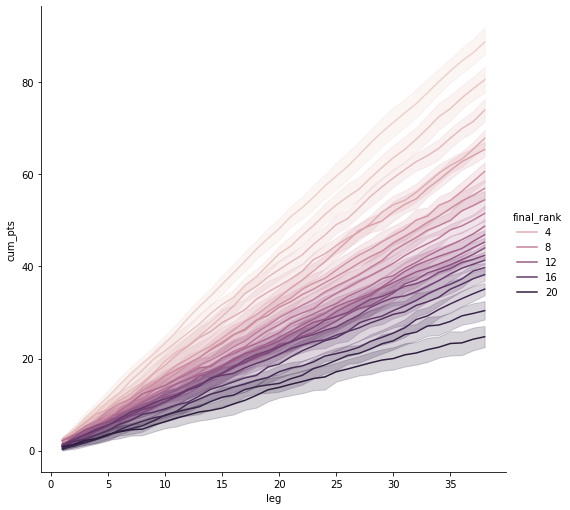

In [50]:
plot_seaborn_kpi(data=serieA_data, kpi='cum_pts')

In [ ]:
# plot_plotly_kpi(df=df, kpi='cum_pts', not_show_standard_deviation=True)

## Rank

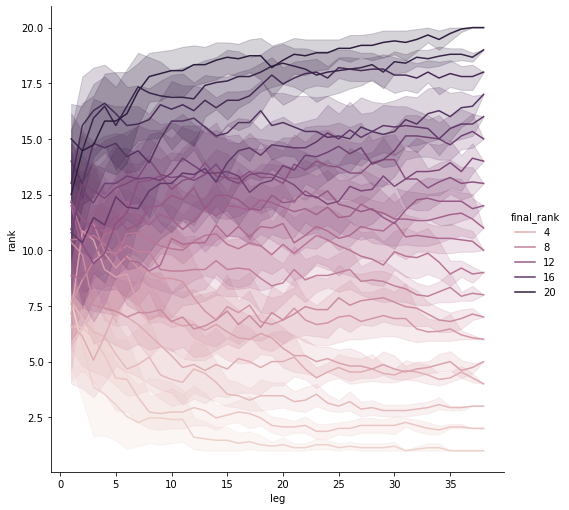

In [51]:
plot_seaborn_kpi(data=serieA_data, kpi='rank')

In [ ]:
# plot_plotly_kpi(df=df, kpi='rank', not_show_standard_deviation=True)

In [ ]:
# https://plotly.com/python/sankey-diagram/

#### Sankey Approach

In [ ]:
sankey_df = serieA_data[['season', 'team', 'leg', 'rank']].rename(columns={"leg": "source_leg", "rank": "source_rank"})
sankey_df_2 = serieA_data[['season', 'team', 'leg', 'rank']].rename(columns={"leg": "target_leg", "rank": "target_rank"})

In [ ]:
sankey_df_2['source_leg'] = sankey_df_2['target_leg'] - 1

In [ ]:
# sankey_df_2

In [ ]:
sankey_df_3 = sankey_df.merge(sankey_df_2, on=['season', 'source_leg', 'team'], how='inner')

In [ ]:
# sankey_df_3.head()

In [ ]:
cnt_df = sankey_df_3.groupby(
    by=['source_leg','source_rank', 'target_leg', 'target_rank'])['team'].count().reset_index()

cnt_df.rename(columns={"team" : 'cnt'}, inplace=True) 

In [ ]:
cnt_df.loc[:,'source_node'] = cnt_df[['source_leg', 'source_rank']].apply(lambda r : 'leg_{}_rank_{}'.format(
    r[0], r[1]), axis=1)

In [ ]:
cnt_df.loc[:,'target_node'] = cnt_df[['target_leg', 'target_rank']].apply(lambda r : 'leg_{}_rank_{}'.format(
    r[0], r[1]), axis=1)

In [ ]:
# cnt_df

In [ ]:
node_2_key = {node :i for i, node in enumerate(
    ['leg_{}_rank_{}'.format(leg, rnk) for rnk in range(1,21) for leg in range(1,39)])}

In [ ]:
# node_2_key

In [ ]:
# data = json.loads(response.read())

# override gray link colors with 'source' colors
# opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
#data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
#data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                    for src in data['data'][0]['link']['source']]

def show_sankey(sankey_data, start_leg=1, end_leg=38):
    
    sankey_data = sankey_data[(sankey_data.source_leg >= start_leg)&(sankey_data.source_leg<end_leg)]
    node_2_key = {node :i for i, node in enumerate(
        ['leg_{}_rank_{}'.format(leg, rnk) for rnk in range(1,21) for leg in range(start_leg, end_leg+1)])}
    
    go_layers = [go.Sankey(
        valueformat = ".0f",
        # valuesuffix = "TWh",
        # Define nodes
        node = dict(
           # x = [.1 + .03*x for x in range(end_leg - start_leg + 1)],
           # y = [.8 - y*.03 for y in range(1,21)],
          pad = 7,
          thickness = 5,
          line = dict(color = "black", width = 0.5),
          label =  ['leg_{}_rank_{}'.format(leg, rnk) for rnk in range(1,21) for leg in range(start_leg, end_leg+1)],
          color =  [color_name_to_rgba(name=color_2_position[rnk], fill=0.8) 
                    for rnk in range(1,21) for leg in range(start_leg, end_leg+1)]
        ),
        # Add links
        link = dict(
          source = [node_2_key[source_node] for source_node in sankey_data['source_node'].values],
          target = [node_2_key[target_node] for target_node in sankey_data['target_node'].values],
          value =  sankey_data['cnt'].values,
          # label =  data['data'][0]['link']['label'],
          color =  [color_name_to_rgba(name=color_2_position[rnk], fill=0.4) 
                    for rnk in sankey_data.source_rank.values]
    ))]


    layout = go.Layout(
                autosize=True, #False,
                width=1200,
                height=1200,

                xaxis= go.layout.XAxis(linecolor = 'black',
                                      linewidth = 1,
                                      mirror = True),

                yaxis= go.layout.YAxis(linecolor = 'black',
                                      linewidth = 1,
                                      mirror = True),

                margin=go.layout.Margin(
                    l=50,
                    r=50,
                    b=100,
                    t=100,
                    pad = 4
                )
            )


    sankey_fig = go.Figure(data=go_layers, layout=layout)
    sankey_fig.update_layout(title_text="Rank evolution",
                      font_size=10)
    sankey_fig.show()

In [ ]:
show_sankey(sankey_data=cnt_df, start_leg=26, end_leg=38)

## Comparison with average point evolution 

In [52]:
serieA_data.team.unique()

array(['Bologne', 'Parme', 'Lecce', 'Brescia', 'Inter Milan', 'Palerme',
       'Juventus Turin', 'Atalanta Bergame', 'Fiorentina', 'Cagliari',
       'Messine', 'AS Rome', 'Lazio Rome', 'Reggina', 'AC Milan',
       'Livourne', 'Chievo Vérone', 'Sienne', 'Sampdoria Gênes',
       'Udinese', 'Empoli', 'Ascoli', 'Trévise', 'Torino', 'Catane',
       'Naples', 'Genoa', 'Bari', 'Cesena', 'Novare', 'Pescara',
       'Hellas Vérone', 'Sassuolo', 'Frosinone', 'Carpi', 'Crotone',
       'SPAL', 'Benevento'], dtype=object)

In [53]:
def compare_pts_evol_with_avg_evolution(data, team, season='2018-2019', until_leg=38, compare_with=None):
    """
    :param data: pd.DataFrame: data containing the league performance
    :param team: str: name of the team we want to analyze
    :param season: str: season we're interested in
    :param until_leg: int: plot team's pts evolution from legs 1 to until leg included
    :param compare_with: str: name of the team whose average pts evolution is computed and which is used for 
    comparison. That Team MUST have played at least 5 seasons
    """
    team_data = deepcopy(data[(data.team == team) & (data.season==season) & (data.leg <= until_leg)])
    comparator_data = deepcopy(data[data.team==compare_with])
    
    nb_season = comparator_data.season.nunique()
    if nb_season < 4 or len(team_data)==0:
        raise ValueError(f"""{team} has not played season {season} or {comparator_data} has played at most 
                         4 games. Please review your inputs""")
        
    avg_comparator_data = comparator_data[['leg', 'cum_pts']].groupby(
        by=['leg']).mean().reset_index().rename(columns={'cum_pts':'avg_cum_pts'})
    
    go_layers= [
    go.Scatter(name=f"{compare_with} averaged",
               x=avg_comparator_data['leg'],
               y=avg_comparator_data['avg_cum_pts'],
               mode='lines',
               line=dict(color="red",
                        width=5)
                   ),
     go.Scatter(name=team,
                x=team_data['leg'],
                y=team_data['cum_pts'],
                mode='lines',
                line=dict(color="royalblue",
                          width=2)
                 )
    ]
    
    layout = go.Layout(
            autosize=True, #False,
            width=800,
            height=800,

            xaxis= go.layout.XAxis(linecolor = 'black',
                                  linewidth = 1,
                                  mirror = True),

            yaxis= go.layout.YAxis(linecolor = 'black',
                                  linewidth = 1,
                                  mirror = True),

            margin=go.layout.Margin(
                l=50,
                r=50,
                b=100,
                t=100,
                pad = 4
            )
        )

    fig = go.Figure(data=go_layers, layout=layout)

    fig.update_layout(
        yaxis_title="number of points",
        title=f"{team}'s point evolution during season {season} wrt to {compare_with} average pts evolution",
        hovermode="x"
    )

    #fig.update_layout(
    #    autosize=False,
    #    width=800,
    #    height=800)

    fig.show() 
    

In [57]:
compare_pts_evol_with_avg_evolution(data=serieA_data, 
                                    team= 'AS Rome', #'Lyon', 
                                    season='2008-2009', 
                                    until_leg=38, 
                                    compare_with='AS Rome')

In [58]:
def compare_pts_evol_time(data, team, until_leg=38):
    """
    :param data: pd.DataFrame: data containing the league performance
    :param team: str: name of the team we want to analyze
    :param until_leg: int: plot team's pts evolution from legs 1 to until leg included
    comparison. That Team MUST have played at least 5 seasons
    """
    team_data = deepcopy(data[(data.team == team) & (data.leg <= until_leg)])
    comparator_data = deepcopy(data[data.team==team])
    
    nb_season = comparator_data.season.nunique()
    if nb_season < 4 or len(team_data)==0:
        raise ValueError(f"""{team} has not played season {season} or has not played at least 
                         5 games. Please change team""")
        
    avg_comparator_data = comparator_data[['leg', 'cum_pts']].groupby(
        by=['leg']).mean().reset_index().rename(columns={'cum_pts':'avg_cum_pts'})
    
    go_layers= [
    go.Scatter(name="averaged point evolution",
               x=avg_comparator_data['leg'],
               y=avg_comparator_data['avg_cum_pts'],
               mode='lines',
               line=dict(color="red",
                        width=5)
                   )]
    i = 0
    for season_start in range(2004,2019):
        i+=1
        season = f'{season_start}-{season_start+1}'
        sublayer = [
         go.Scatter(name=season,
                    x=team_data[team_data.season==season]['leg'],
                    y=team_data[team_data.season==season]['cum_pts'],
                    mode='lines',
                    line=dict(color=color_2_position[i],
                              width=2)
                     )
        ]
        
        go_layers+=sublayer
    
    layout = go.Layout(
            autosize=True, #False,
            width=800,
            height=800,

            xaxis= go.layout.XAxis(linecolor = 'black',
                                  linewidth = 1,
                                  mirror = True),

            yaxis= go.layout.YAxis(linecolor = 'black',
                                  linewidth = 1,
                                  mirror = True),

            margin=go.layout.Margin(
                l=50,
                r=50,
                b=100,
                t=100,
                pad = 4
            )
        )

    fig = go.Figure(data=go_layers, layout=layout)

    fig.update_layout(
        yaxis_title="number of points",
        title=f"{team}'s point evolution over its {nb_season} seasons wrt to its average pts evolution",
        hovermode="x"
    )

    #fig.update_layout(
    #    autosize=False,
    #    width=800,
    #    height=800)

    fig.show() 
    
    

In [59]:
compare_pts_evol_time(data=serieA_data,
                     team='AS Rome', #'Paris-SG',
                     until_leg=38)


## Cumulative goals scored

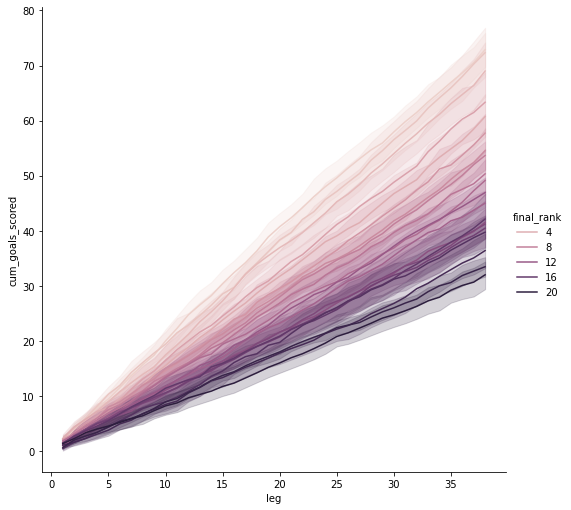

In [60]:
plot_seaborn_kpi(data=serieA_data, kpi='cum_goals_scored')

In [ ]:
plot_plotly_kpi(df=df, kpi='cum_goals_scored', not_show_standard_deviation=True)

## Cumulative goal difference 

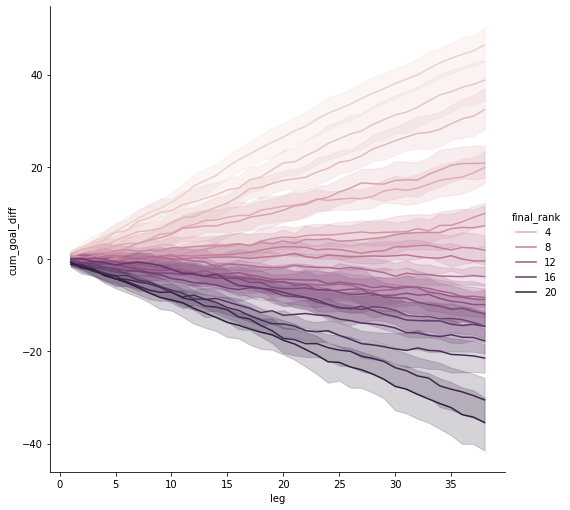

In [61]:
plot_seaborn_kpi(data=serieA_data, kpi='cum_goal_diff')

In [ ]:
plot_plotly_kpi(df=df, kpi='cum_goal_diff', not_show_standard_deviation=True)

## Goal scored

In [ ]:
plot_seaborn_kpi(data=serieA_data, kpi='goals_scored')

In [62]:
plot_plotly_kpi(df=df, kpi='goals_scored', not_show_standard_deviation=True)

## Goal conceded

In [ ]:
plot_seaborn_kpi(data=serieA_data, kpi='goals_conceded')

In [63]:
plot_plotly_kpi(df=df, kpi='goals_conceded', not_show_standard_deviation=True)

## Scatter plot : 
#### x : nbr goals scored,
#### y: nbr scored conceded, 
#### color : final rank or current rank

In [68]:
def plot_plotly_scatter(df, color, season=None):
    if color not in ['rank', 'final_rank']:
        raise ValueError(f"color MUST be rank or final_rank. Got {color}")
    
    if season:
        df=df[df.season == season]
    go_layers = []
    for ranking in sorted(df.final_rank.unique(), reverse=False):
        dg = deepcopy(df[df[color] == ranking])
        
        dg.loc[:, 'goals_scored'] = dg['goals_scored'].apply(lambda x: x+random.uniform(0, .5))
        dg.loc[:, 'goals_conceded'] = dg['goals_conceded'].apply(lambda x: x+random.uniform(0, .5))
        
        sublayer = [
        go.Scatter(
            name=str(ranking),
            x=dg['goals_scored'],
            y=dg['goals_conceded'],
            mode='markers',
            line=dict(color=color_2_position[ranking],
                     width=2 if ranking not in [3, 18] else 5)
                )
        ]
        go_layers+=sublayer



    layout = go.Layout(
        autosize=True, #False,
        width=800,
        height=800,

        xaxis= go.layout.XAxis(linecolor = 'black',
                              linewidth = 1,
                              mirror = True),

        yaxis= go.layout.YAxis(linecolor = 'black',
                              linewidth = 1,
                              mirror = True),

        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad = 4
        )
    )

    fig = go.Figure(data=go_layers, layout=layout)

    fig.update_layout(
        yaxis_title='Goals conceded',
        xaxis_title='Goals scored',
        title=f"Scatterplot goals scored/conceded. Color is related to {color} column",
        hovermode="x"
    )

    #fig.update_layout(
    #    autosize=False,
    #    width=800,
    #    height=800)

    fig.show()

In [67]:
plot_plotly_scatter(df=serieA_data, color='rank', season='2018-2019')

## Histogram

In [69]:
def plot_plotly_histogram(df, x, color, season=None):
    if color not in ['rank', 'final_rank', 'previous_team_rank', 'previous_opponent_rank']:
        raise ValueError(f"color MUST be rank or final_rank. Got {color}")
        
    if x not in ['goals_scored', 'goals_conceded']:
        raise ValueError(f"x MUST be goals_scored or goals_conceded. Got {x}")
        
    if season:
        df=df[df.season == season]
        
    go_layers = []
    for ranking in sorted(df.final_rank.unique(), reverse=False):
        dg = deepcopy(df[df[color] == ranking])
        
        
        sublayer = [
        go.Histogram(
            name=str(ranking),
            x=dg[x].values,
            marker=dict(line=dict(color=color_2_position[ranking],
                     width=2 if ranking not in [3, 18] else 5)
                ))
        ]
        go_layers+=sublayer



    layout = go.Layout(
        autosize=True, #False,
        width=800,
        height=800,

        xaxis= go.layout.XAxis(linecolor = 'black',
                              linewidth = 1,
                              mirror = True),

        yaxis= go.layout.YAxis(linecolor = 'black',
                              linewidth = 1,
                              mirror = True),

        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad = 4
        )
    )

    fig = go.Figure(data=go_layers, layout=layout)
    
    disp_season = season if season else 'all'
    
    fig.update_layout(
        yaxis_title='nb. times',
        xaxis_title='Goals scored',
        title=f"Histogram of {x} for {disp_season}. Color is related to {color} column",
        hovermode="x"
    )
    
    # Overlay both histograms
    fig.update_layout(barmode='overlay')
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.5)

    #fig.update_layout(
    #    autosize=False,
    #    width=800,
    #    height=800)

    fig.show()

In [ ]:
#tmp_df = deepcopy(ligue1_data[['season', 'leg', 'team', 'rank']])
#tmp_df.loc[:,'next_leg'] = tmp_df['leg'] +1

In [ ]:
#tmp_df.rename(columns={'leg': 'previous_leg', 'next_leg':'leg', 'rank':'previous_rank'}, inplace=True)

In [ ]:
#tmp_df

In [ ]:
#ligue1_data_dev = ligue1_data.merge(tmp_df, how='left', on=['leg', 'season', 'team'])

In [ ]:
# ligue1_data_dev[ligue1_data_dev.leg==1]

In [ ]:
# ligue1_data

In [70]:
plot_plotly_histogram(df=serieA_data, x='goals_scored', color='previous_team_rank', season='2018-2019')

In [71]:
def hist_aggregator(df, column_to_describe, aggreg_column='play', bin_step=None):
    if bin_step is not None:
        df[f'{aggreg_column}_binned'] = df[aggreg_column].apply(lambda x : (x//bin_step)*bin_step)
        aggreg_column = f'{aggreg_column}_binned'
        
    df_agg = df[[aggreg_column, column_to_describe, 'country']].groupby(
        by=[aggreg_column, column_to_describe]).count().reset_index()
    df_agg.rename(columns={'country': 'cnt'}, inplace=True)
    return df_agg

In [72]:
def mean_aggregator(df, column_to_describe, aggreg_column='play', bin_step=None):
    if bin_step is not None:
        df[f'{aggreg_column}_binned'] = df[aggreg_column].apply(lambda x : (x//bin_step)*bin_step)
        aggreg_column = f'{aggreg_column}_binned'
        
    df_agg = df[[aggreg_column, column_to_describe]].groupby(
        by=[aggreg_column]).mean().reset_index()
    df_agg.rename(columns={column_to_describe: f'avg_{column_to_describe}'}, inplace=True)
    return df_agg

In [73]:
hist_aggregator(df=serieA_data, column_to_describe='goals_scored', aggreg_column='previous_team_rank')

,previous_team_rank,goals_scored,cnt
0,1.0,0,78
1,1.0,1,178
2,1.0,2,172
3,1.0,3,81
4,1.0,4,34
...,...,...,...
132,20.0,1,209
133,20.0,2,101
134,20.0,3,26
135,20.0,4,6


In [74]:
def draw_pie_chart(df, values, names, hover_data, title):  
    if isinstance(names, list):
        name = '_'.join(names)
        df[name] = df[names].apply(lambda r: '_'.join([str(_) for _ in r]), axis=1)
    else:
        name = names
    # hover_data = [hover_data] if isinstance(hover_data, str) else hover_data
    #fig = px.pie(df, values=values, names=name,
    #             title=title,
                 # hover_data=[hover_data]
                 #, labels={'lifeExp':'life expectancy'}
     #           )
    
    fig = go.Figure(data=[go.Pie(labels=df[name], values=df[values])])
    fig.update_traces(title_text=title, textposition='inside', textinfo='percent+label')
    fig.show()

In [75]:
def draw_sunburst(df, path, values, color=None):
    fig = px.sunburst(df, path=path, values=values, color=color)
    # fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

# Home/Away advantage : pts won; goal scored; goal conceded

# TO DO : Pie Charts

In [76]:
home_away_goals_scored = hist_aggregator(df=serieA_data, 
                                         column_to_describe='goals_scored',
                                         aggreg_column='play')
home_away_goals_scored

,play,goals_scored,cnt
0,Away,0,1891
1,Away,1,2031
2,Away,2,1127
3,Away,3,455
4,Away,4,138
5,Away,5,40
6,Away,6,5
7,Away,7,3
8,Home,0,1283
9,Home,1,1850


In [77]:
draw_pie_chart(df=home_away_goals_scored, values='cnt', 
               names=['play','goals_scored'],
               title='nb. of goals when playing home/away', 
               hover_data=['play','goals_scored'])

In [78]:
draw_sunburst(df=home_away_goals_scored,
             path=['play','goals_scored'],
             values='cnt')

In [79]:
draw_pie_chart(df=home_away_goals_scored, values='cnt', 
               names='goals_scored',
               title='nb. of goals', 
               hover_data=['play','goals_scored'])

In [81]:
home_pts = hist_aggregator(df=serieA_data[serieA_data.play=='Home'], 
                           column_to_describe='nb_points', 
                           aggreg_column='play')
home_pts

,play,nb_points,cnt
0,Home,0,1540
1,Home,1,1520
2,Home,3,2630


In [82]:
draw_pie_chart(df=home_pts, values='cnt', names='nb_points', title='Home performance', hover_data='nb_points')

## Leg on goals

In [83]:
leg_on_perf_at_home = hist_aggregator(df=serieA_data[serieA_data.play=='Home'],
                                      column_to_describe='nb_points', 
                                      aggreg_column='leg')
leg_on_perf_at_home

,leg,nb_points,cnt
0,1,0,36
1,1,1,26
2,1,3,79
3,2,0,43
4,2,1,32
...,...,...,...
109,37,1,48
110,37,3,57
111,38,0,34
112,38,1,32


In [86]:
draw_pie_chart(df=deepcopy(leg_on_perf_at_home[leg_on_perf_at_home.nb_points==1]), values='cnt', 
               names=['leg'],
               title='Legs on ties when playing home', 
               hover_data=['leg',])

In [87]:
draw_sunburst(df=leg_on_perf_at_home,
             path=['leg', 'nb_points'],
             values='cnt')

In [88]:
leg_goals = hist_aggregator(df=serieA_data, column_to_describe='goals_scored', aggreg_column='leg')
leg_goals

,leg,goals_scored,cnt
0,1,0,67
1,1,1,86
2,1,2,80
3,1,3,33
4,1,4,10
...,...,...,...
249,38,2,86
250,38,3,46
251,38,4,15
252,38,5,9


In [89]:
draw_sunburst(df=leg_goals,
             path=['leg', 'goals_scored'],
             values='cnt')

## Average all ongoing season goals scored / opponent avg goals conceded on number goals scored  --> Scatterplot with jitter + bins the avg by steps of 0.1 goals

In [91]:
# scatterplot on hist : change to hist bar
def draw_scatterplot(df, x, y, size_col, title):
    fig = px.scatter(df, x=x, y=y, size=size_col, title=title)
    fig.show()


# line on mean
def draw_line(df, x, y, title):
    fig = px.line(df, x=x, y=y, title=title)
    fig.show()

In [ ]:
#'previous_opponent_avg_goals_conceded_since_season_start',
#'previous_team_avg_goals_score_since_season_start'

In [92]:
opponent_season_perf_on_goals_hist = hist_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_opponent_avg_goals_conceded_since_season_start',
                bin_step=.1)
opponent_season_perf_on_goals_hist


,previous_opponent_avg_goals_conceded_since_season_start_binned,goals_scored,cnt
0,0.0,0,31
1,0.0,1,25
2,0.0,2,25
3,0.0,3,13
4,0.0,4,3
...,...,...,...
184,4.4,0,1
185,4.9,1,2
186,4.9,2,2
187,4.9,4,1


In [93]:
draw_scatterplot(df=opponent_season_perf_on_goals_hist,
                 x='previous_opponent_avg_goals_conceded_since_season_start_binned',
                 y='goals_scored',
                 size_col='cnt',
                 title='Opponent avg goals conceded since season start vs goals to be scored')

In [94]:
opponent_season_perf_on_goals_mean = mean_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_opponent_avg_goals_conceded_since_season_start',
                bin_step=.1)
opponent_season_perf_on_goals_mean

,previous_opponent_avg_goals_conceded_since_season_start_binned,avg_goals_scored
0,0.0,1.420000
1,0.1,1.333333
2,0.2,1.344828
3,0.3,1.282051
4,0.4,1.320513
5,0.5,1.362573
6,0.6,1.365942
7,0.7,1.195846
8,0.8,1.269380
9,0.9,1.272812


In [95]:
draw_line(df=opponent_season_perf_on_goals_mean,
          x='previous_opponent_avg_goals_conceded_since_season_start_binned',
          y='avg_goals_scored', 
          title='Opponent avg goals conceded since season start vs avg goals to be scored')

In [96]:
team_season_perf_on_goals_hist = hist_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_avg_goals_scored_since_season_start',
                bin_step=.1)
team_season_perf_on_goals_hist.head()

,previous_team_avg_goals_scored_since_season_start_binned,goals_scored,cnt
0,0.0,0,27
1,0.0,1,33
2,0.0,2,26
3,0.0,3,4
4,0.0,4,3


In [97]:
draw_scatterplot(df=team_season_perf_on_goals_hist, 
                 x='previous_team_avg_goals_scored_since_season_start_binned',
                 y='goals_scored',
                 size_col='cnt',
                 title='Team avg goals scored since season start vs goals to be scored')

In [99]:
team_season_perf_on_goals_mean = mean_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_avg_goals_scored_since_season_start',
                bin_step=.1)
team_season_perf_on_goals_mean.head()

,previous_team_avg_goals_scored_since_season_start_binned,avg_goals_scored
0,0.0,1.284211
1,0.1,1.500000
2,0.2,0.909091
3,0.3,1.000000
4,0.4,0.952096


In [100]:
draw_line(df=team_season_perf_on_goals_mean,
          x='previous_team_avg_goals_scored_since_season_start_binned', 
          y='avg_goals_scored',
          title='Team avg goals scored since season start vs avg goals to be scored')

## Average 5 last game goals scored / opponent avg goals conceded on number goals scored --> Scatterplot with jitter

In [ ]:
#'previous_opponent_rolling_5_games_avg_goals_conceded',
#'previous_team_rolling_5_games_avg_goals_scored'

In [101]:
opponent_last5_perf_on_goals_hist = hist_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_opponent_rolling_5_games_avg_goals_conceded',
                bin_step=.1)
opponent_last5_perf_on_goals_hist

,previous_opponent_rolling_5_games_avg_goals_conceded_binned,goals_scored,cnt
0,0.0,0,9
1,0.0,1,21
2,0.0,2,10
3,0.0,3,6
4,0.0,4,3
...,...,...,...
110,3.2,3,1
111,3.3,1,5
112,3.3,2,1
113,3.7,2,1


In [102]:
draw_scatterplot(df=opponent_last5_perf_on_goals_hist, 
                 x='previous_opponent_rolling_5_games_avg_goals_conceded_binned',
                 y='goals_scored',
                 size_col='cnt',
                 title='5 leg Avg on opponents goals conceded vs goals to be scored')

In [103]:
opponent_last5_perf_on_goals_mean = mean_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_opponent_rolling_5_games_avg_goals_conceded',
                bin_step=.1)
opponent_last5_perf_on_goals_mean

,previous_opponent_rolling_5_games_avg_goals_conceded_binned,avg_goals_scored
0,0.0,1.448980
1,0.2,1.317647
2,0.4,1.294253
3,0.5,1.302168
4,0.8,1.281640
5,0.9,1.327229
6,1.1,1.332640
7,1.3,1.351866
8,1.6,1.375116
9,1.7,1.283981


In [104]:
draw_line(df=opponent_last5_perf_on_goals_mean,
          x='previous_opponent_rolling_5_games_avg_goals_conceded_binned',
          y='avg_goals_scored',
          title='5 leg Avg on opponents goals conceded vs avg goals to be scored')

In [105]:
team_last5_perf_on_goals_hist = hist_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_rolling_5_games_avg_goals_scored',
                bin_step=.1)
team_last5_perf_on_goals_hist

,previous_team_rolling_5_games_avg_goals_scored_binned,goals_scored,cnt
0,0.0,0,7
1,0.0,1,8
2,0.0,2,2
3,0.0,3,4
4,0.0,4,2
...,...,...,...
118,3.5,3,3
119,3.7,1,4
120,3.7,2,1
121,3.7,3,1


In [106]:
draw_scatterplot(df=team_last5_perf_on_goals_hist,
                 x='previous_team_rolling_5_games_avg_goals_scored_binned',
                 y='goals_scored',
                 size_col='cnt',
                 title='5 leg Avg on Team goals scored vs goals to be scored')

In [107]:
team_last5_perf_on_goals_mean = mean_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_rolling_5_games_avg_goals_scored',
                bin_step=.1)
team_last5_perf_on_goals_mean

,previous_team_rolling_5_games_avg_goals_scored_binned,avg_goals_scored
0,0.0,1.391304
1,0.2,1.109091
2,0.4,1.102679
3,0.5,1.094382
4,0.8,1.190396
5,0.9,1.192533
6,1.1,1.286770
7,1.3,1.359080
8,1.6,1.432879
9,1.7,1.390013


In [108]:
draw_line(df=team_last5_perf_on_goals_mean,
          x='previous_team_rolling_5_games_avg_goals_scored_binned',
          y='avg_goals_scored',
          title='5 leg Avg on Team goals scored vs avg goals to be scored')

# LAST GAME PERFORMANCE

##### Team

In [109]:
last_game_team_goals_scored_hist = hist_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_goals_scored',
                bin_step=None)
last_game_team_goals_scored_hist

,previous_team_goals_scored,goals_scored,cnt
0,0.0,0,926
1,0.0,1,1061
2,0.0,2,676
3,0.0,3,300
4,0.0,4,117
5,0.0,5,24
6,0.0,6,7
7,0.0,7,2
8,1.0,0,1062
9,1.0,1,1335


In [110]:
draw_scatterplot(df=last_game_team_goals_scored_hist,
                 x='previous_team_goals_scored',
                 y='goals_scored',
                 size_col='cnt', 
                 title='Team previous game goals scored vs goals to be scored')

In [111]:
last_game_team_goals_scored_mean = mean_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_goals_scored',
                bin_step=None)
last_game_team_goals_scored_mean

,previous_team_goals_scored,avg_goals_scored
0,0.0,1.271121
1,1.0,1.285752
2,2.0,1.364040
3,3.0,1.364028
4,4.0,1.426020
5,5.0,1.594595
6,6.0,1.736842
7,7.0,2.111111


In [112]:
draw_line(df=last_game_team_goals_scored_mean, 
          x='previous_team_goals_scored', 
          y='avg_goals_scored',
          title='Team previous game goals scored vs avg goals to be scored')

##### Opponent

In [113]:
last_game_opponent_goals_conceded_hist = hist_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_opponent_goals_conceded',
                bin_step=None)
last_game_opponent_goals_conceded_hist

,previous_opponent_goals_conceded,goals_scored,cnt
0,0.0,0,847
1,0.0,1,1054
2,0.0,2,702
3,0.0,3,350
4,0.0,4,113
5,0.0,5,35
6,0.0,6,8
7,0.0,7,4
8,1.0,0,1046
9,1.0,1,1304


In [114]:
draw_scatterplot(df=last_game_opponent_goals_conceded_hist,
                 x='previous_opponent_goals_conceded',
                 y='goals_scored',
                 size_col='cnt',
                 title='Opponent previous game goals conceded vs goals to be scored')

In [115]:
last_game_opponent_goals_conceded_mean = mean_aggregator(df=serieA_data, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_opponent_goals_conceded',
                bin_step=None)
last_game_opponent_goals_conceded_mean

,previous_opponent_goals_conceded,avg_goals_scored
0,0.0,1.352714
1,1.0,1.325520
2,2.0,1.298990
3,3.0,1.274527
4,4.0,1.237245
5,5.0,1.261261
6,6.0,1.000000
7,7.0,1.000000


In [116]:
draw_line(df=last_game_opponent_goals_conceded_mean,
          x='previous_opponent_goals_conceded',
          y='avg_goals_scored',
          title='Opponent previous game goals conceded vs avg goals to be scored')

# ANNEXE

In [ ]:
def show_named_plotly_colours():
    """
    function to display to user the colours to match plotly's named
    css colours.

    Reference:
        #https://community.plotly.com/t/plotly-colours-list/11730/3

    Returns:
        plotly dataframe with cell colour to match named colour name

    """
    s='''
        aliceblue, antiquewhite, aqua, aquamarine, azure,
        beige, bisque, black, blanchedalmond, blue,
        blueviolet, brown, burlywood, cadetblue,
        chartreuse, chocolate, coral, cornflowerblue,
        cornsilk, crimson, cyan, darkblue, darkcyan,
        darkgoldenrod, darkgray, darkgrey, darkgreen,
        darkkhaki, darkmagenta, darkolivegreen, darkorange,
        darkorchid, darkred, darksalmon, darkseagreen,
        darkslateblue, darkslategray, darkslategrey,
        darkturquoise, darkviolet, deeppink, deepskyblue,
        dimgray, dimgrey, dodgerblue, firebrick,
        floralwhite, forestgreen, fuchsia, gainsboro,
        ghostwhite, gold, goldenrod, gray, grey, green,
        greenyellow, honeydew, hotpink, indianred, indigo,
        ivory, khaki, lavender, lavenderblush, lawngreen,
        lemonchiffon, lightblue, lightcoral, lightcyan,
        lightgoldenrodyellow, lightgray, lightgrey,
        lightgreen, lightpink, lightsalmon, lightseagreen,
        lightskyblue, lightslategray, lightslategrey,
        lightsteelblue, lightyellow, lime, limegreen,
        linen, magenta, maroon, mediumaquamarine,
        mediumblue, mediumorchid, mediumpurple,
        mediumseagreen, mediumslateblue, mediumspringgreen,
        mediumturquoise, mediumvioletred, midnightblue,
        mintcream, mistyrose, moccasin, navajowhite, navy,
        oldlace, olive, olivedrab, orange, orangered,
        orchid, palegoldenrod, palegreen, paleturquoise,
        palevioletred, papayawhip, peachpuff, peru, pink,
        plum, powderblue, purple, red, rosybrown,
        royalblue, saddlebrown, salmon, sandybrown,
        seagreen, seashell, sienna, silver, skyblue,
        slateblue, slategray, slategrey, snow, springgreen,
        steelblue, tan, teal, thistle, tomato, turquoise,
        violet, wheat, white, whitesmoke, yellow,
        yellowgreen
        '''
    li=s.split(',')
    li=[l.replace('\n','') for l in li]
    li=[l.replace(' ','') for l in li]

    import pandas as pd
    import plotly.graph_objects as go

    df=pd.DataFrame.from_dict({'colour': li})
    fig_col = go.Figure(data=[go.Table(
      header=dict(
        values=["Plotly Named CSS colours"],
        line_color='black', fill_color='white',
        align='center', font=dict(color='black', size=14)
      ),
      cells=dict(
        values=[df.colour],
        line_color=[df.colour], fill_color=[df.colour],
        align='center', font=dict(color='black', size=11)
      ))
    ])

    fig_col.show()

In [ ]:
show_named_plotly_colours()

In [ ]:
color_2_position = {1: "royalblue",
                   2: "aqua",
                   3: "cornflowerblue",
                   4: "chartreuse",
                   5: "yellowgreen",
                   6: "green",
                   7: "teal",
                   8: "purple",
                   9: "mediumturquoise",
                   10: "plum",
                   11: "khaki",
                   12: "goldenrod",
                   13: "yellow",
                   14: "chocolate",
                   15: "lightpink",
                   16: "hotpink",
                   17: "lightsalmon",
                   18: "orange",
                   19: "orangered",
                   20: "red"}